# UTS klasifikasi pada data berita dengan ektraksi fitur menggunakan LDA

## Install dependencies 

In [1]:
%pip install tomotopy umap-learn scikit-learn gensim matplotlib tqdm

   ---------------------------------------- 3.9/3.9 MB 1.2 MB/s  0:00:03
   ---------------------------------------- 8.9/8.9 MB 2.6 MB/s  0:00:03
   ---------------------------------------- 2.7/2.7 MB 2.8 MB/s  0:00:01
   ---------------------------------------- 38.1/38.1 MB 2.1 MB/s  0:00:18
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.0
    Uninstalling scikit-learn-1.2.0:
      Successfully uninstalled scikit-learn-1.2.0

Note: you may need to restart the kernel to use updated packages.


## Import libraries

In [2]:
import tomotopy as tp
from gensim import corpora
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
import umap
import matplotlib.pyplot as plt

## Import Data

In [ ]:
import pandas as pd
df = pd.read_csv("datasets/df_preprocessing.csv")
documents = df["tokenize_indo"].tolist()
labels = df["Kategori Berita"].tolist()

## Membuat Dictionary dan Corpus

In [4]:
from gensim.corpora import Dictionary

# Membuat kamus dan corpus
texts = [doc.split() for doc in documents]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

print(f"Jumlah kata unik: {len(dictionary)}")

Jumlah kata unik: 18713


## HDP untuk estimasi jumlah topik

In [5]:
hdp = tp.HDPModel(min_cf=2, rm_top=5)
for doc in texts:
    hdp.add_doc(doc)

for i in tqdm(range(0, 1000, 10)):
    hdp.train(10)

print(f"Perkiraan jumlah topik dari HDP: {hdp.live_k}")

100%|██████████| 100/100 [00:20<00:00,  4.92it/s]

Perkiraan jumlah topik dari HDP: 44


## Latih Model LDA dengan Tomotopy

In [6]:
num_topics = hdp.live_k  # bisa juga pakai nilai manual seperti 15
lda = tp.LDAModel(k=num_topics, min_cf=2, rm_top=5)

for doc in texts:
    lda.add_doc(doc)

for i in tqdm(range(0, 1000, 10)):
    lda.train(10)

print(f"Model LDA selesai dilatih dengan {lda.k} topik.")

100%|██████████| 100/100 [00:10<00:00,  9.46it/s]

Model LDA selesai dilatih dengan 44 topik.


## Ekstrak Fitur dari LDA

In [7]:
lda_vectors = [lda.docs[i].get_topic_dist() for i in range(len(lda.docs))]
X = np.array(lda_vectors)
y = np.array(labels)

print("Shape fitur LDA:", X.shape)

Shape fitur LDA: (1200, 44)


## Visualisasi Distribusi Topik dengan UMAP

c:\Users\willy\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


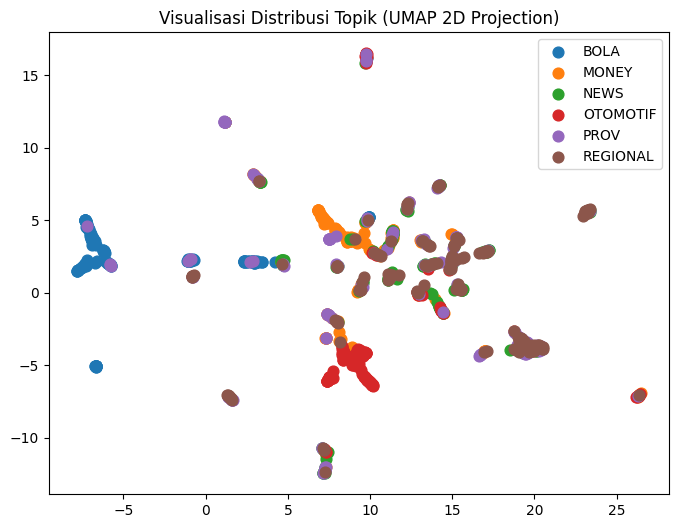

In [8]:
reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X)

plt.figure(figsize=(8,6))
for label in np.unique(y):
    idx = y == label
    plt.scatter(X_umap[idx, 0], X_umap[idx, 1], label=label, s=60)
plt.title("Visualisasi Distribusi Topik (UMAP 2D Projection)")
plt.legend()
plt.show()

## Klasifikasi Menggunakan SVM

In [9]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='linear', random_state=42))
])

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')

print(f"Akurasi Rata-rata: {scores.mean()*100:.2f}% (+/- {scores.std()*100:.2f}%)")

Akurasi Rata-rata: 68.25% (+/- 2.41%)


## Simpan Model 

In [10]:
# import joblib
# joblib.dump(lda, "lda_model.pkl")
# joblib.dump(pipeline, "svm_classifier.pkl")
# print("Model berhasil disimpan.")